In [1]:
# Function that does n iterations of RMS calculation

import numpy as np
import matplotlib.pyplot as plt

def mc_rms (y_array1, y_array2, unc1, unc2, n):
    '''Function that does n iterations of RMS calculation.
    
    Arguments: y_array1, y_array2, unc1, unc2, n
    Outputs: [avg, error, RMS]
    '''
    plt.clf()
    
    RMS=[]

    for w in range(n):
        y_array1_rand = y_array1 + (np.random.randn(len(y_array1)) * unc1)
        y_array2_rand = y_array2 + (np.random.randn(len(y_array2)) * unc2)
        diff = y_array1_rand - y_array2_rand
        rms = (np.sum(diff**2))/(len(diff))**(0.5)
        RMS.append(rms)
       
    avg = np.mean(RMS)
    error = np.std(RMS)
#     print('RMS = ',avg, '+/-', error)
#     print(avg)
    return [avg, error, RMS]
    
    RMS.sort()
#     plt.hist(RMS, bins=50)
#     plt.ylabel('Frequency')
#     plt.xlabel('RMS')
#     plt.show()

#     label = '/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png'

#     plt.savefig(label)
    
#     print(RMS)

In [2]:
# Derived from ycfq_auto:

#yfcq_auto
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d
# import BDdb
import astrodb
import pandas as pd
%matplotlib inline
import matplotlib.mlab as mlab
from scipy.stats import norm

db = astrodb.Database('/Users/victoriaditomasso/Desktop/BDNYCdeprecated.db')

# The inputs are the target source id, the spec order being compared and the path to the text file with the comparison sample (has to be tab delimited)
def yfcq(tar_source_id, spec_order, path_to_comp_sample_dataframe):
    '''Thus function generates a plot showing the output of different numbers of MCMC iterations.
    
    Inputs: tar_source_id, spec_order, path_to_comp_sample_dataframe
    Outputs: Saves image files, returns nothing.'''

# This clears the figure, useful when saving the plots
    plt.clf()

    data_tar = db.query("select sources.id, sources.shortname, spectra.wavelength, spectra.flux, spectra.unc, radial_velocities.radial_velocity from sources join spectra on sources.id=spectra.source_id join radial_velocities on spectra.source_id=radial_velocities.source_id where spectra.source_id={} and spectra.wavelength_order={}".format(tar_source_id, spec_order))

    df=pd.read_csv(path_to_comp_sample_dataframe,sep='\t')

    for i, row in df.iterrows() :

        plt.clf()
        
#Gets the wavelength, flux, and uncertainty for the spec_ids listed in comp_sample
        data_comp = db.query("select spectra.wavelength, spectra.flux, spectra.unc from spectra where spectra.id={}".format(row['spec_id']))
    
# Separates out the wavelength array, flux array, RV and uncertainty as a float for the two spectra	
        w_tar = np.asarray(data_tar[0][2])
        f_tar = np.asarray(data_tar[0][3])

        w_comp = np.asarray(data_comp[0][0])
        f_comp = np.asarray(data_comp[0][1])

        rv_tar = data_tar[0][5]
        rv_comp = row['rv']

        unc_tar = data_tar[0][4]
        unc_comp = data_comp[0][2]

# Shifts the two spectra based on their RVs
        shifted_w_tar = (w_tar)*(1.-(rv_tar/2.99792458e5))
        shifted_w_comp = (w_comp)*(1.-(rv_comp/2.99792458e5))

# Interpolates the flux for the comp object so that when I subtract it from the target flux, I will get a properly calculated residual
# Remember: once you interpolate, you need to plot the w_tar vs the interpolated flux NOT w_comp vs interpolated flux
        x = shifted_w_tar
        xp = shifted_w_comp
        fp = f_comp
        f_comp_interp = np.interp(x, xp, fp)

#Checking if unc arrays are actually snrs and, if they are, converting them by doing 1/unc
        unc=np.asarray(unc_comp)
        avg_unc = np.sum(unc)/len(unc)
        if avg_unc > 4.0:
            unc_comp = 1.0/unc
#         if avg_unc == 1.0:
#             print 'UNC AVG = 1:'

# Interpolate the unc
        w = shifted_w_tar
        wp = shifted_w_comp
        up = unc_comp
        unc_comp_interp = np.interp(w, wp, up)

# Finds a normalization coefficient	
        dk = sum((f_tar * f_comp)/((unc_tar)**2 + (unc_comp_interp)**2))/sum((f_comp * f_comp)/((unc_tar)**2 + (unc_comp_interp)**2))

# Creates an array of normalized flux for the comparison object
        f_comp_norm_dk = f_comp * dk
        f_comp_norm_dk_interp = f_comp_interp * dk

# Sets the first and last flux point that will be used in quantification calculation/will be plotted
        f=50
        l=1000
        
# MC_rms calculation
        
        y_array1 = f_tar[f:l]
        y_array2 = f_comp_norm_dk_interp[f:l]
        unc1 = unc_tar[f:l]
        unc2 = unc_comp_interp[f:l]

        plot_title=str(row['shortname']) + '_' + str(data_tar[0][1])
        plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png')
        
#         fig, axes = plt.subplots(4,1)
#         fig=plt.figure()
#         iterations = [100,200,500,1000]
        
        fig = plt.subplots(4,1) 
    
        for i in [1000, 1500, 2000, 2500]:
            
            rms = mc_rms(y_array1, y_array2, unc1, unc2, i)
            
            plt.hist(rms[2],bins=25, normed=True)
            plt.title(i)
            
            mean = np.mean(rms[2])
            variance = np.var(rms[2])
            sigma = np.sqrt(variance)
            x = np.linspace(min(rms[2]), max(rms[2]), 100)
            plt.plot(x, mlab.normpdf(x, mean, sigma))
            print('mean = ', mean, 'sigma = ', sigma)
            
            column_title = 'RMS n=' + str(i)
            df[column_title] = rms[0]
            df.to_csv(str(data_tar[0][1])+'_'+str(spec_order)+'testing_mc.txt',sep='\t')
            plot_title=str(row['shortname']) + '_' + str(data_tar[0][1]) + '_' +str(i)
        
#             (rms[0],rms[1]) = norm.fit(rms[2])
#             y = mlab.normpdf(25,rms[0],rms[1])
#             x = np.linspace(min(rms[2]),max(rms[2]),num=len(y))
#             plt.plot(x,y)
            plt.show()
            
            plt.savefig('/Users/victoriaditomasso/phys767/MCSpectra/hist_'+str(plot_title)+'.png')



Database ready for use


mean =  0.118470068214 sigma =  0.0029595900772


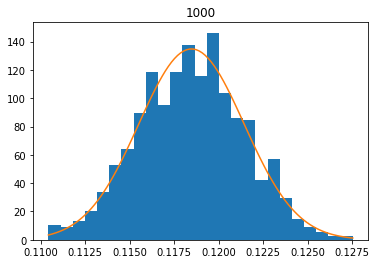

mean =  0.11857031763 sigma =  0.00297323034217


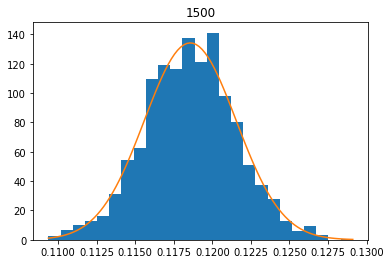

mean =  0.118578273778 sigma =  0.00306194203659


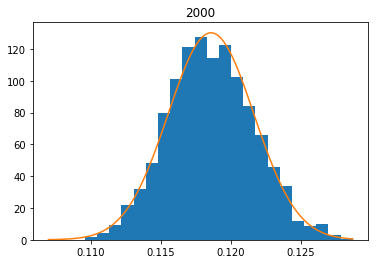

mean =  0.118511581661 sigma =  0.00302015457141


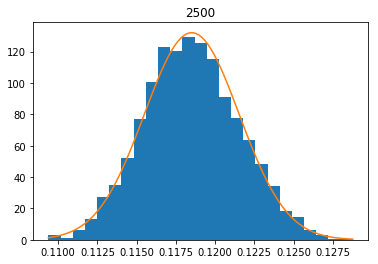

mean =  0.122177183413 sigma =  0.00264512583937


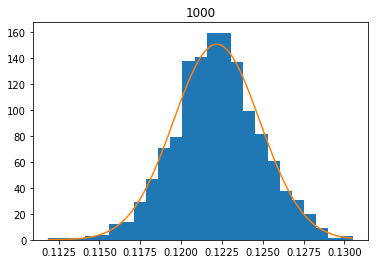

mean =  0.122116687247 sigma =  0.00264877919516


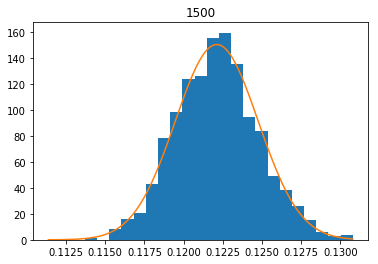

mean =  0.122126062285 sigma =  0.00267566573957


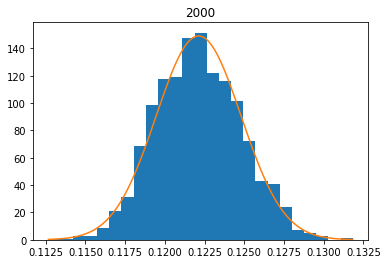

mean =  0.122131763627 sigma =  0.00264238664444


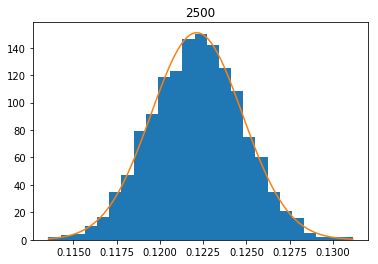

mean =  0.0841163316941 sigma =  0.00212325904058


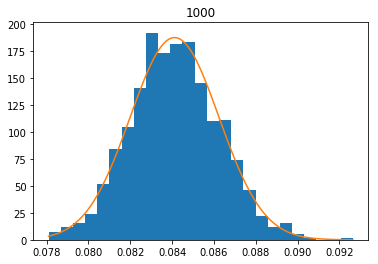

mean =  0.0841881701375 sigma =  0.00216697970293


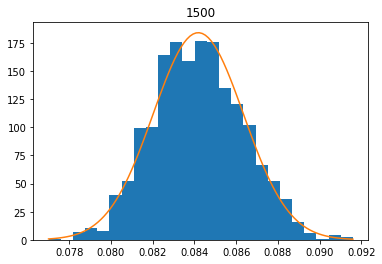

mean =  0.0841362499891 sigma =  0.00219718001544


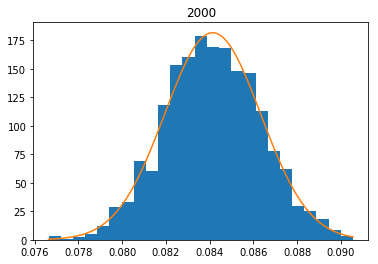

mean =  0.0840289224524 sigma =  0.00217557841358


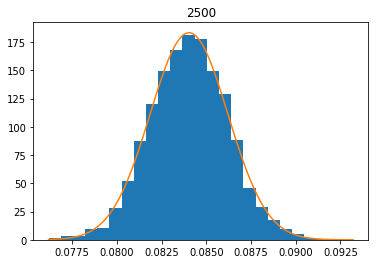

mean =  0.0964935299859 sigma =  0.00354129648662


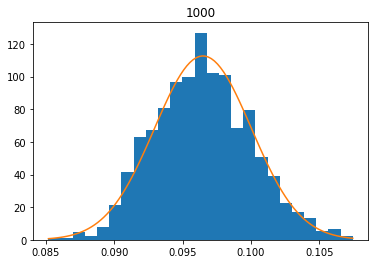

mean =  0.0964230092262 sigma =  0.00360082269323


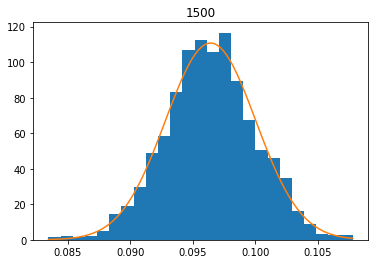

mean =  0.0965034398152 sigma =  0.00354528354256


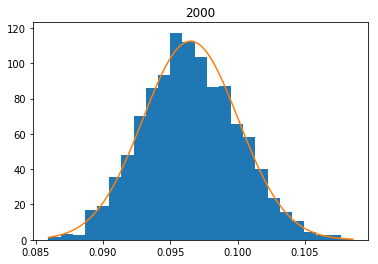

mean =  0.0965679517794 sigma =  0.00359544746986


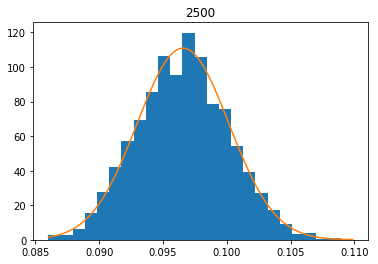

mean =  0.08091865596 sigma =  0.0022096822253


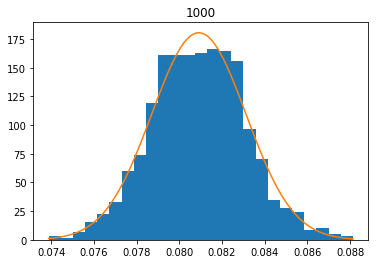

mean =  0.0808187353652 sigma =  0.00213038878658


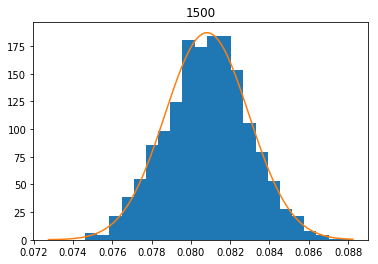

mean =  0.0807860287285 sigma =  0.00219563418151


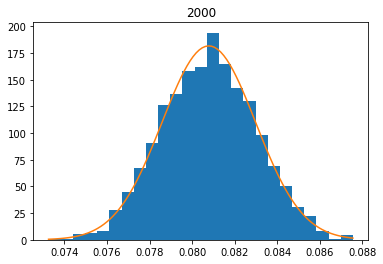

mean =  0.0807860459033 sigma =  0.00218768362675


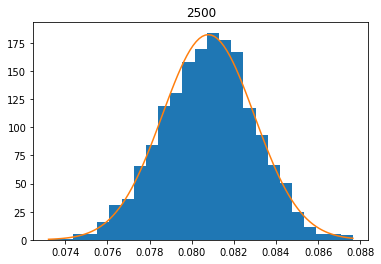

mean =  0.0610496677915 sigma =  0.00180242936677


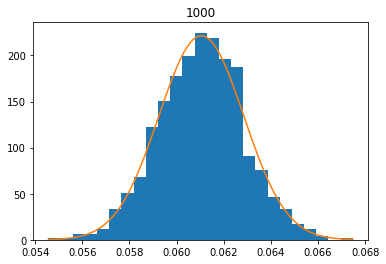

mean =  0.0611115207112 sigma =  0.00172621050631


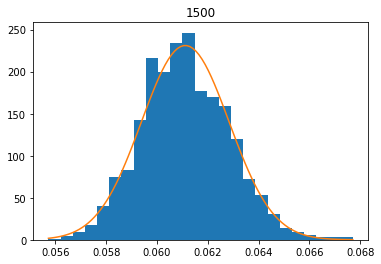

mean =  0.0610918659392 sigma =  0.00183317215605


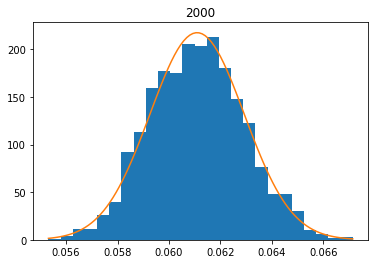

mean =  0.0610749592055 sigma =  0.00179306453061


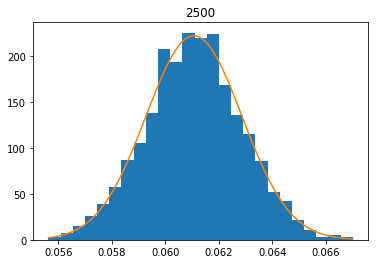

mean =  0.136091322333 sigma =  0.00345820235619


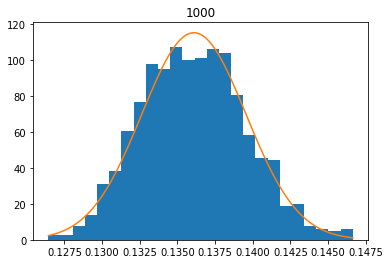

mean =  0.136209697704 sigma =  0.00355670024806


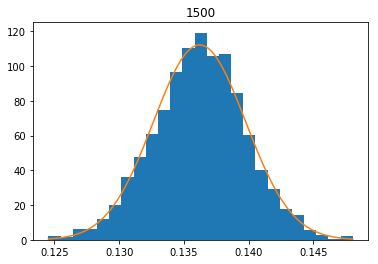

mean =  0.136157292738 sigma =  0.00357727652713


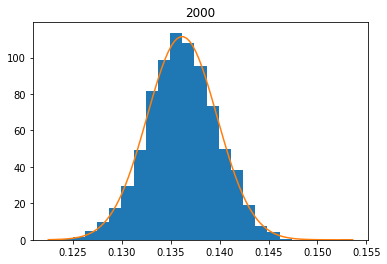

mean =  0.136188253458 sigma =  0.00349665976325


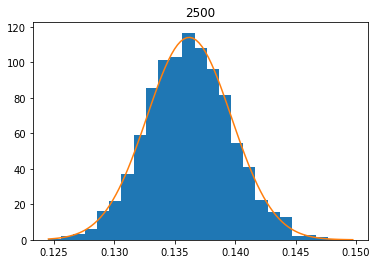

mean =  0.118547814998 sigma =  0.00312254941411


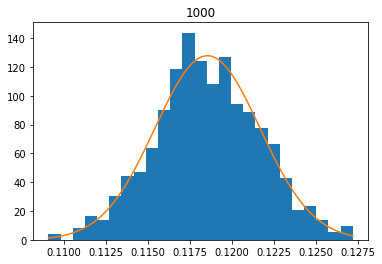

In [ ]:
yfcq(334, 61, "/Users/victoriaditomasso/phys767/comp_sample_order_61_bad_removed.txt")

In [ ]:
yfcq(98, 61, "/Users/victoriaditomasso/Plotting_Spectra/comp_sample_order_61_badremoved.txt")